# Results
* Experiments carried on SMAP, MSL and SWaT dataset
    * swat_ori: Original SWaT dataset obtained from SUTD
    * swat: Downsampled dataset used in GDN (Reduced to 10%)
    * smap_m: all 55 entities (25 columns; 1st column = Telemetry values) concatenated row-wise + min max scaling
    * smap_tel: 1st column of every 55 entities concatenated column-wise
    * smap_tel_m: 1st column of every 55 entities concatenated column-wise + min max scaling
    * msl_m: all 27 entities (55 columns; 1st column = Telemetry values) concatenated row-wise
    * msl_tel: 1st column of every 27 entities concatenated column-wise
    * msl_tel_m: 1st column of every 27 entities concatenated column-wise + min max scaling
* Only Train data are sampled at 10%, 30%, 50%, 70% and 90% for above datasets i.e. same test data is used through different sampling rate.
* Additional datasets created (denoted with 'all') whereby both train and test data are sampled at the same rate.
* Import compile_result.py to convert result.json file to csv
</hr>

# Load Libraries

In [1]:
from compile_result import compile_result, print_result
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Function Definition

In [2]:
def change_sequence(dataset):
    new_list = [f"{dataset}_{i}" for i in range(10, 110, 20)]
    
    if dataset.endswith('all'):
        new_list.append(dataset.rsplit('_', 1)[0])
    else:
        new_list.append(dataset)
    
    return new_list



def plot_sampling(df_data, dataset):
    
    color_code = {
    'F1 Score': 'red',
    'Precision': 'green',
    'Recall': 'blue',
    }

    dset = {
        'swat': ['swat', 'swat_ori'],
        'swat_all': ['swat_all', 'swat_ori_all'],
        'smap': ['smap_m', 'smap_tel', 'smap_tel_m'],
        'smap_all': ['smap_m_all', 'smap_tel_all', 'smap_tel_m_all'],
        'msl': ['msl_m', 'msl_tel', 'msl_tel_m'],
        'msl_all': ['msl_m_all', 'msl_tel_all', 'msl_tel_m_all'],
    }
    
    x = [10, 30, 50, 70, 90, 100]
    col = len(dset[dataset])
    subplot_no = 1
    
    if col == 2:
        plt.figure(figsize=(12, 6))
    else:
        plt.figure(figsize=(8, 12))
    
    for var in dset[dataset]:
        
        if col == 2:
            plt.subplot(1, col, subplot_no)
        else:
            plt.subplot(col, 1, subplot_no)
            
        x_list = change_sequence(var)
        
        for metric in color_code.keys():
            y = df_data.loc[x_list, metric].tolist()
            plt.plot(x, y, color=color_code[metric], label=metric)
        
        plt.ylim(0.1, 1)        
        plt.xlabel('Sampling', fontsize=14)
        plt.ylabel('Score', fontsize=14)
        plt.title('Random Sampling on '+var.upper(), fontsize=14)
        plt.legend()
        subplot_no += 1

    plt.tight_layout()
    plt.show()



def plot_telemetry(df_smap, df_msl):
    
    x = [10, 30, 50, 70, 90, 100]
    d = {'smap_tel': df_smap, 'msl_tel': df_msl}
        
    for metric in ['F1 Score', 'Precision', 'Recall']:
        
        plt.figure(figsize=(12, 6))
        subplot_no = 1
        
        for dataset, df_data in d.items():
            plt.subplot(1, 2, subplot_no)
            color_code = {dataset: 'blue', dataset+'_m': 'red'}
            
            for var in [dataset, dataset+'_m']:
                x_list = change_sequence(var)
                y = df_data.loc[x_list, metric].tolist()
                labels = 'No Scaling' if var == dataset else 'Min Max Scaling'
                plt.plot(x, y, color=color_code[var], label=labels)

            plt.xlabel('Sampling', fontsize=14)
            plt.ylabel(metric, fontsize=14)
            plt.title(f"{dataset} ({metric})", fontsize=14)
            plt.ylim(0.5, 1)
            plt.legend()
            subplot_no += 1

        plt.tight_layout()
        plt.show()



def plot_box(df_data, dataset, para_list=['Slide_Win', 'FC_Layer_Num', 'Topk'], metric='F1 Score'):
    
    plt.figure(figsize=(12,6))
    subplot_no = 1
    
    for para in para_list:
        if len(para_list) > 1:
            plt.subplot(1, 3, subplot_no)
        
        sns.set_style("whitegrid")
        sns.boxplot(x=para, y=metric, data=df_data)
        
        plt.xlabel(para) # Set text for the x axis
        plt.ylabel(metric)# Set text for y axis
        plt.title(f"{metric} for {dataset.upper()} by {para}")
        subplot_no += 1
    
    plt.tight_layout()
    plt.show()
    

    
def plot_parameter(df_data, dataset):
        
    dset = {
        'swat': ['swat', 'swat_ori'],
        'smap': ['smap_m', 'smap_tel'],
        'msl': ['msl_m', 'msl_tel'],
    }
    
    d_list = []
    
    for name in dset[dataset]:
        d = df_data.loc[df_data['Dataset'].str.startswith(name),:]
        d_list.append(d)
        plot_box(d, name)
    
    return d_list



def plot_box_sampling(df_data, dataset):
        
    dset = {
        'swat': ['swat', 'swat_ori'],
        'swat_all': ['swat_all', 'swat_ori_all'],
        'smap': ['smap_m', 'smap_tel', 'smap_tel_m'],
        'smap_all': ['smap_m_all', 'smap_tel_all', 'smap_tel_m_all'],
        'msl': ['msl_m', 'msl_tel', 'msl_tel_m'],
        'msl_all': ['msl_m_all', 'msl_tel_all', 'msl_tel_m_all'],
    }
    
    d_list = []
    data = df_data['Dataset']
      
    for name in dset[dataset]:
        cond1 = data.str.startswith(name)
        cond2 = cond1 | (data == name.rsplit('_', 1)[0])
        
        if name == 'swat':
            d = df_data.loc[~data.str.startswith('swat_ori'),:].reset_index(drop=True)
            
        elif name.endswith('all'):
            d = df_data.loc[cond2,:].reset_index(drop=True)
            
        else:
            d = df_data.loc[cond1,:].reset_index(drop=True)
       
        # Append 'sample' column i.e. random sampling percentage to dataframe
        last = d['Dataset'].apply(lambda x: str(x).split('_')[-1])
        d['sample'] = last.apply(lambda y: 100 if y.isalpha() else int(y))
        d.sort_values(by=['sample'])
        
        d_list.append(d)
        plot_box(d, name, para_list=['sample'])
        
    return d_list



def plot_sampling_all(df_data, df_data_all, dataset):
    
    dset = {
        'swat': ['swat', 'swat_ori'],
        'smap': ['smap_m', 'smap_tel', 'smap_tel_m'],
        'msl': ['msl_m', 'msl_tel', 'msl_tel_m'],
    }
    
    score = 'F1 Score'
    x = [10, 30, 50, 70, 90, 100]
    col = len(dset[dataset])
    subplot_no = 1
    
    if col == 2:
        plt.figure(figsize=(12, 6))
    else:
        plt.figure(figsize=(8, 12))
    
    for var in dset[dataset]:
        
        if col == 2:
            plt.subplot(1, col, subplot_no)
        else:
            plt.subplot(col, 1, subplot_no)
        
        # Plot sampled train and unsampled test
        x_list = change_sequence(var)
        y = df_data.loc[x_list, score].tolist()
        plt.plot(x, y, color='red', label='unsampled')
        
        # Plot sampled train and test
        x_list_all = change_sequence(var+'_all')
        y_all = df_data_all.loc[x_list_all, score].tolist()
        plt.plot(x, y_all, color='blue', label='sampled')

        plt.ylim(0.1, 1)
        plt.xlabel('Sampling', fontsize=14)
        plt.ylabel(score, fontsize=14)
        plt.title('Sampled vs Unsampled Test Data for '+var.upper(), fontsize=14)
        plt.legend()
        subplot_no += 1

    plt.tight_layout()
    plt.show()




# Read Json files
* Experimental results stored in result.json
* Json files are stored in results folder

In [3]:
df = compile_result('result.json')
path = Path.cwd().joinpath('results', 'result.csv')
df.to_csv(path, index=False)
df


********************************************************************************

Highest F1 Score   : smap_tel_all_10      [0.9239302694136291]       -> (20, 3, 10)
Highest Precision  : swat_all_10          [1.0]                      -> (20, 3, 10)
Highest Recall     : smap_m               [1.0]                      -> (10, 3, 20)

********************************************************************************



,Date_Time,Dataset,Epoch,Slide_Win,Dim,Slide_Stride,FC_Layer_Num,FC_Dim,Decay,Val_Ratio,Topk,F1 Score,Precision,Recall,Confusion Matrix,Anomalies
0,"28-Sep-2022, 12:20:28",anomaly,100,30,64,2,2,128,0.10,0.1,2,0.059182,0.032661,0.317757,"[[33604, 1007], [73, 34]]",0.0031
1,"28-Sep-2022, 12:52:18",anomaly,100,30,64,2,2,128,0.10,0.1,20,0.081119,0.047776,0.271028,"[[34033, 578], [78, 29]]",0.0031
2,"28-Sep-2022, 13:24:07",anomaly,100,30,64,2,2,128,0.10,0.1,25,0.079618,0.048077,0.233645,"[[34116, 495], [82, 25]]",0.0031
3,"28-Sep-2022, 13:56:01",anomaly,100,30,64,2,2,128,0.01,0.1,2,0.060160,0.032421,0.420561,"[[33268, 1343], [62, 45]]",0.0031
4,"28-Sep-2022, 14:27:02",anomaly,100,30,64,2,2,128,0.01,0.1,20,0.054422,0.029630,0.336449,"[[33432, 1179], [71, 36]]",0.0031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,"31-Oct-2022, 04:23:13",adasyn_s,100,20,64,1,3,128,0.00,0.1,5,0.635869,0.500237,0.872388,"[[27790, 66488], [9735, 66551]]",0.4473
2166,"31-Oct-2022, 04:32:24",adasyn_s,100,5,64,1,2,128,0.00,0.1,20,0.643585,0.506317,0.882979,"[[28600, 65685], [8928, 67366]]",0.4473
2167,"31-Oct-2022, 05:49:13",adasyn_s,100,10,64,1,3,128,0.00,0.1,10,0.632842,0.491148,0.889453,"[[23976, 70305], [8434, 67859]]",0.4473
2168,"31-Oct-2022, 05:51:57",adasyn_s,100,10,64,1,3,128,0.00,0.1,5,0.639010,0.501553,0.880264,"[[27539, 66742], [9135, 67158]]",0.4473


In [4]:
data = {}

# Split dataset to swat, smap, and msl
for d in ['swat', 'smap', 'msl']:
    df_temp = df.loc[df['Dataset'].str.startswith(d),:].sort_values(by=['Dataset', 'Slide_Win', 'FC_Layer_Num', 'Topk'])
    d_set = df_temp['Dataset']
    
    # Further split dataset into all i.e. sampled both train and test data
    df_1 = df_temp.loc[d_set.str.contains('all'),:]
    
    # Include unsampled data for comparision
    df_2 = df_temp.loc[~d_set.str.endswith('0'),:]
    df_all = pd.concat([df_1, df_2], axis=0).sort_values(by=['Dataset', 'Slide_Win', 'FC_Layer_Num', 'Topk'])
    data[d+'_all'] = df_all.reset_index(drop=True)
    
    # Further split data set into not all i.e. sampled only train data
    data[d] = df_temp.loc[~df_temp['Dataset'].str.contains('all')].reset_index(drop=True)

data.keys()

dict_keys(['swat_all', 'swat', 'smap_all', 'smap', 'msl_all', 'msl'])

In [5]:
data['swat_all']

,Date_Time,Dataset,Epoch,Slide_Win,Dim,Slide_Stride,FC_Layer_Num,FC_Dim,Decay,Val_Ratio,Topk,F1 Score,Precision,Recall,Confusion Matrix,Anomalies
0,"03-Oct-2022, 22:37:52",swat,500,5,64,1,2,128,0.0,0.1,5,0.733752,0.995659,0.584562,"[[39479, 14], [2282, 3211]]",0.1221
1,"04-Oct-2022, 04:51:09",swat,500,5,64,1,2,128,0.0,0.1,10,0.756706,0.877914,0.665028,"[[38985, 508], [1840, 3653]]",0.1221
2,"04-Oct-2022, 11:04:01",swat,500,5,64,1,2,128,0.0,0.1,20,0.710962,0.837698,0.617331,"[[38836, 657], [2102, 3391]]",0.1221
3,"04-Oct-2022, 17:39:35",swat,500,5,64,1,3,128,0.0,0.1,5,0.749168,0.914069,0.635172,"[[39165, 328], [2004, 3489]]",0.1221
4,"05-Oct-2022, 00:31:20",swat,500,5,64,1,3,128,0.0,0.1,10,0.803907,0.979597,0.681777,"[[39415, 78], [1748, 3745]]",0.1221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,"29-Oct-2022, 19:07:36",swat_ori_all_90,100,20,64,1,2,128,0.0,0.1,10,0.515903,0.405581,0.708684,"[[304520, 51145], [14345, 34897]]",0.1216
218,"31-Oct-2022, 02:52:58",swat_ori_all_90,100,20,64,1,2,128,0.0,0.1,20,0.735200,0.963679,0.594310,"[[354562, 1103], [19977, 29265]]",0.1216
219,"28-Oct-2022, 12:39:07",swat_ori_all_90,100,20,64,1,3,128,0.0,0.1,5,0.757031,0.993997,0.611957,"[[355483, 182], [19108, 30134]]",0.1216
220,"30-Oct-2022, 01:34:28",swat_ori_all_90,100,20,64,1,3,128,0.0,0.1,10,0.833294,0.979666,0.724991,"[[354924, 741], [13542, 35700]]",0.1216


# Highest F1 Score, Precision and Recall

In [6]:
# Print SWaT, MSL and SMAP dataset with highest F1 Score, Precision and Recall
for k, v in data.items():
    print("\n", k)
    print_result(v)


 swat_all

********************************************************************************

Highest F1 Score   : swat_ori_all_10      [0.8400994200497099]       -> (10, 3, 10)
Highest Precision  : swat_all_10          [1.0]                      -> (20, 3, 10)
Highest Recall     : swat_ori_all_10      [0.8409463148316652]       -> ( 5, 3, 10)

********************************************************************************


 swat

********************************************************************************

Highest F1 Score   : swat_70              [0.8293232312890346]       -> ( 5, 3, 5 )
Highest Precision  : swat_50              [0.9985656913367756]       -> (10, 2, 20)
Highest Recall     : swat_10              [0.8292372109958128]       -> ( 5, 3, 20)

********************************************************************************


 smap_all

********************************************************************************

Highest F1 Score   : smap_tel_all_10      [0.9239302

# Average F1 Score, Precision and Recall

## <font color=red>SWaT</font>

In [7]:
df_swat = data['swat'].get(['Dataset', 'F1 Score', 'Precision', 'Recall', 'Anomalies']).groupby(['Dataset']).mean()
df_swat.to_csv('result_swat.csv')
df_swat

,F1 Score,Precision,Recall,Anomalies
Dataset,,,,
swat,0.711252,0.849546,0.636942,0.1221
swat_10,0.611275,0.645320,0.664674,0.1221
swat_30,0.687290,0.789336,0.647855,0.1221
swat_50,0.696698,0.794642,0.669134,0.1221
swat_60,0.685534,0.777303,0.666869,0.1221
swat_70,0.687277,0.779195,0.660184,0.1221
swat_80,0.684852,0.760858,0.678642,0.1221
swat_90,0.712437,0.831574,0.661114,0.1221
swat_ori,0.658422,0.741291,0.663236,0.1214


In [8]:
df_swat_all = data['swat_all'].get(['Dataset', 'F1 Score', 'Precision', 'Recall', 'Anomalies']).groupby(['Dataset']).mean()
df_swat_all.to_csv('result_swat_all.csv')
df_swat_all

,F1 Score,Precision,Recall,Anomalies
Dataset,,,,
swat,0.711252,0.849546,0.636942,0.122100
swat_all_10,0.627056,0.706170,0.615873,0.117000
swat_all_30,0.688708,0.804470,0.641352,0.121233
swat_all_50,0.683478,0.777326,0.652928,0.123200
swat_all_70,0.644663,0.671871,0.681867,0.122133
swat_all_90,0.742081,0.899483,0.655349,0.122233
swat_ori,0.658422,0.741291,0.663236,0.121400
swat_ori_all_10,0.685043,0.771042,0.681397,0.122167
swat_ori_all_30,0.640276,0.681273,0.685573,0.121900


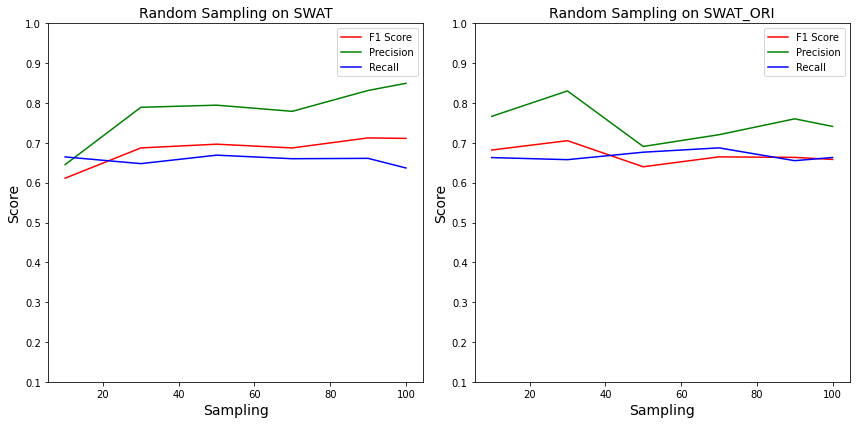

In [9]:
plot_sampling(df_swat, 'swat')

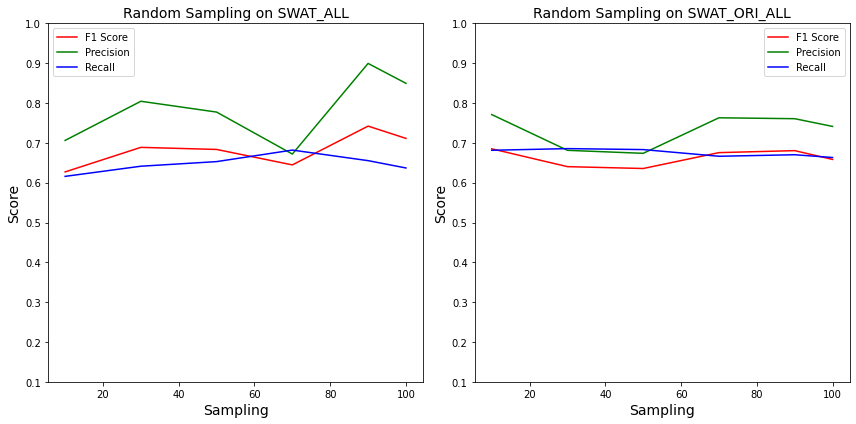

In [10]:
plot_sampling(df_swat_all, 'swat_all')

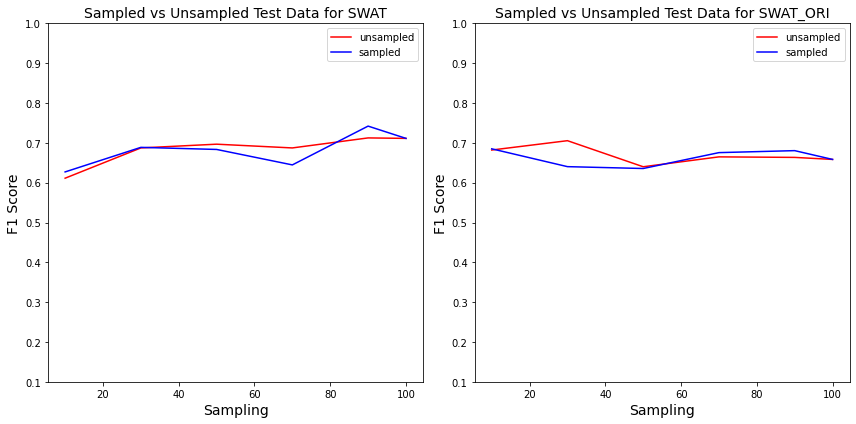

In [11]:
plot_sampling_all(df_swat, df_swat_all, 'swat')

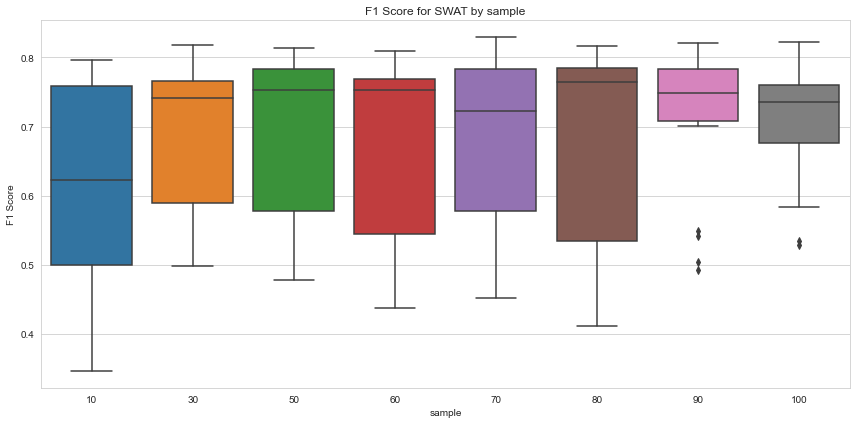

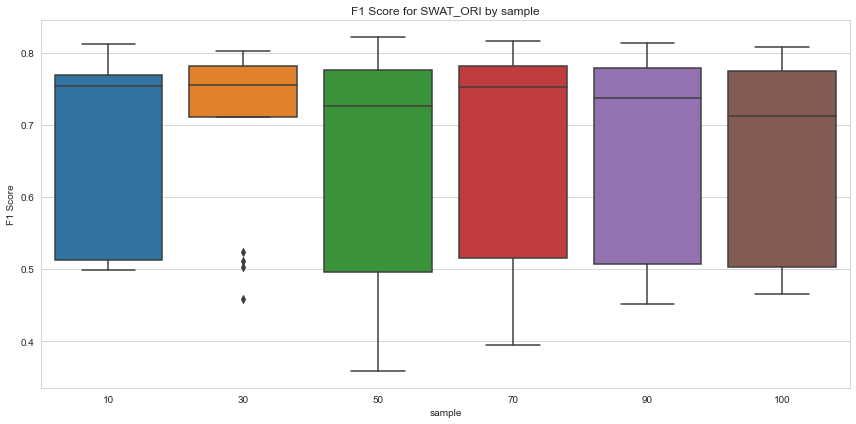

In [12]:
swat, swat_ori = plot_box_sampling(data['swat'], 'swat')

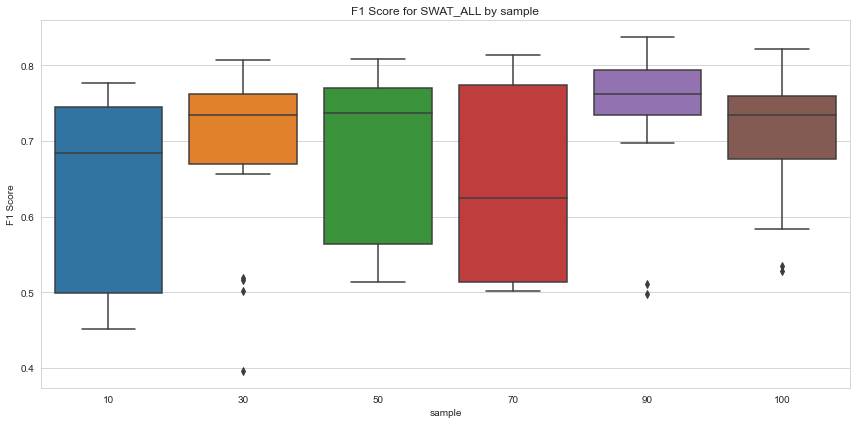

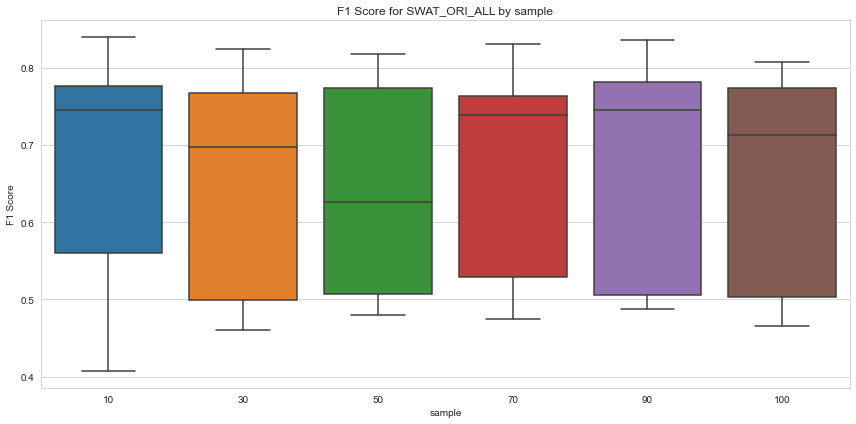

In [13]:
swat_all, swat_ori_all = plot_box_sampling(data['swat_all'], 'swat_all')

## <font color=red>SMAP</font>

In [14]:
df_smap = data['smap'].get(['Dataset', 'F1 Score', 'Precision', 'Recall', 'Anomalies']).groupby(['Dataset']).mean()
df_smap

,F1 Score,Precision,Recall,Anomalies
Dataset,,,,
smap_m,0.242508,0.142731,0.776021,0.1279
smap_m_10,0.252294,0.147960,0.853882,0.1279
smap_m_30,0.250347,0.148784,0.796263,0.1279
smap_m_50,0.247592,0.147606,0.788551,0.1279
smap_m_60,0.287117,0.173787,0.825380,0.1279
smap_m_70,0.251863,0.153896,0.709002,0.1279
smap_m_90,0.237842,0.135577,0.799090,0.1279
smap_tel,0.862226,0.786124,0.962655,0.7386
smap_tel_10,0.862913,0.774910,0.975827,0.7386


In [15]:
df_smap_all = data['smap_all'].get(['Dataset', 'F1 Score', 'Precision', 'Recall', 'Anomalies']).groupby(['Dataset']).mean()
df_smap_all

,F1 Score,Precision,Recall,Anomalies
Dataset,,,,
smap_m,0.242508,0.142731,0.776021,0.127900
smap_m_all_10,0.231708,0.129981,0.931211,0.126967
smap_m_all_30,0.240186,0.137879,0.851577,0.127600
smap_m_all_50,0.248225,0.146559,0.770656,0.127400
smap_m_all_70,0.239243,0.138220,0.890635,0.127600
smap_m_all_90,0.239744,0.134950,0.848440,0.128300
smap_tel,0.862226,0.786124,0.962655,0.738600
smap_tel_all_10,0.873014,0.797076,0.970266,0.749733
smap_tel_all_30,0.864824,0.783637,0.971703,0.746400


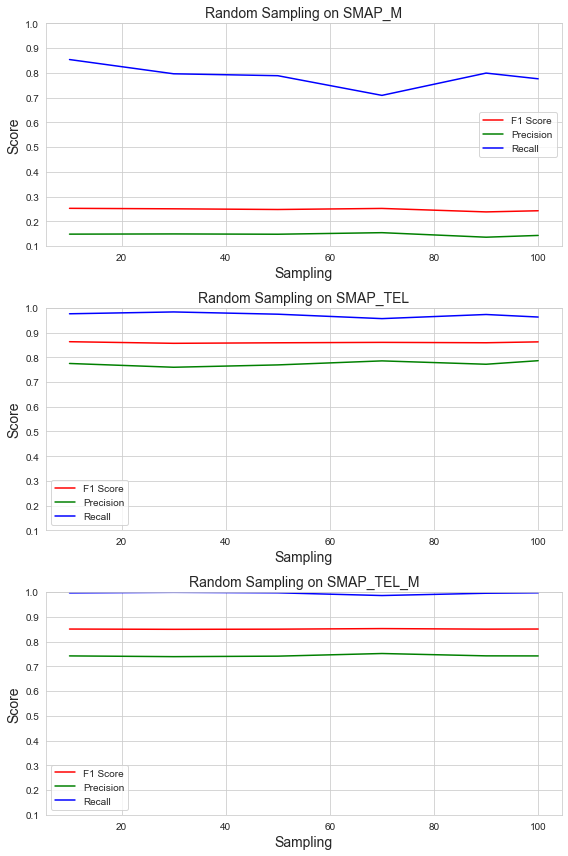

In [16]:
plot_sampling(df_smap, 'smap')

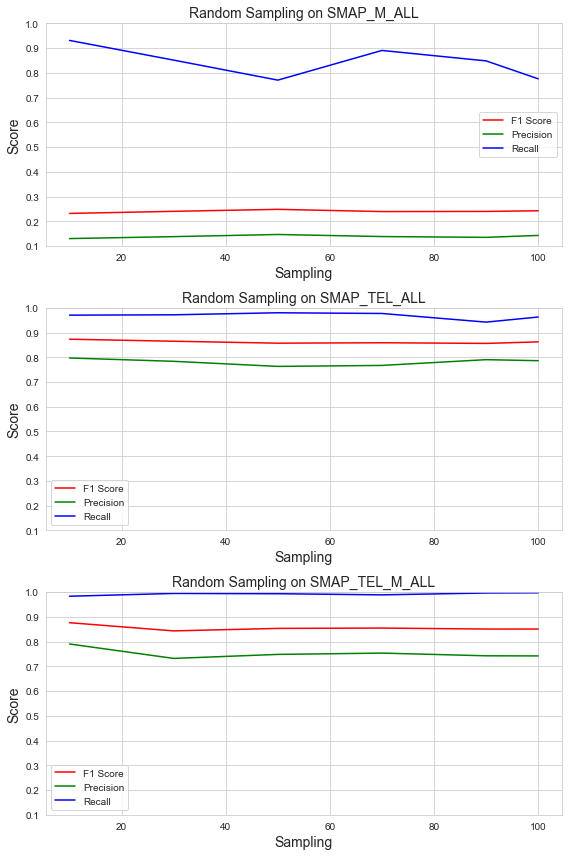

In [17]:
plot_sampling(df_smap_all, 'smap_all')

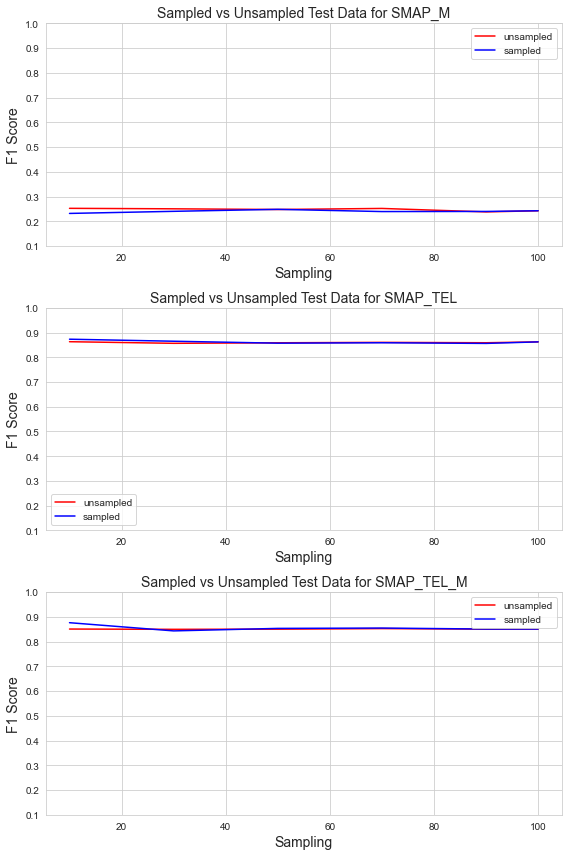

In [18]:
plot_sampling_all(df_smap, df_smap_all, 'smap')

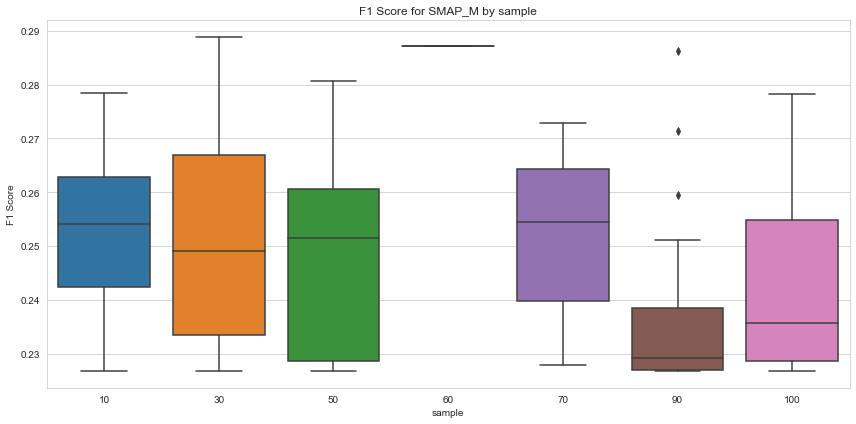

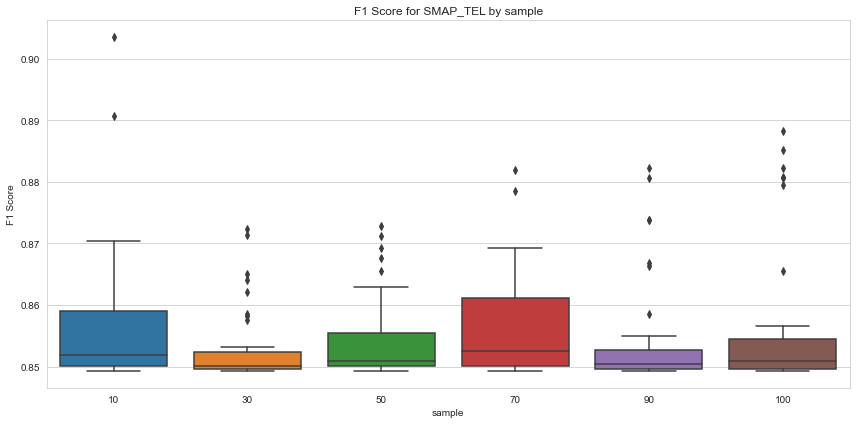

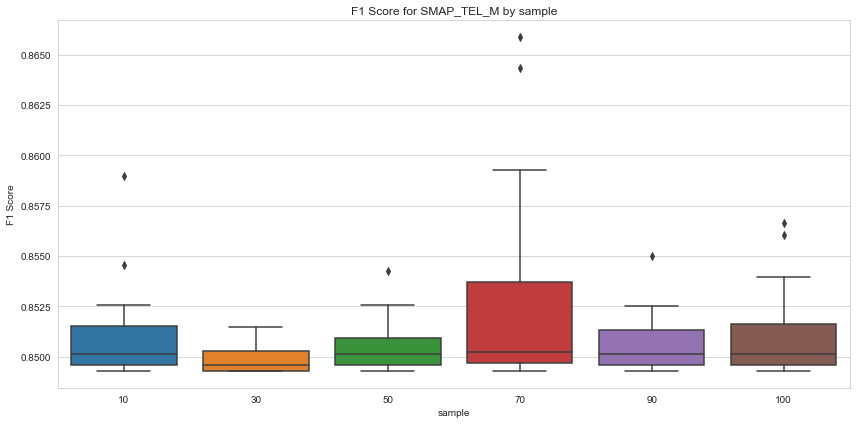

In [19]:
smap, smap_tel, smap_tel_m = plot_box_sampling(data['smap'], 'smap')

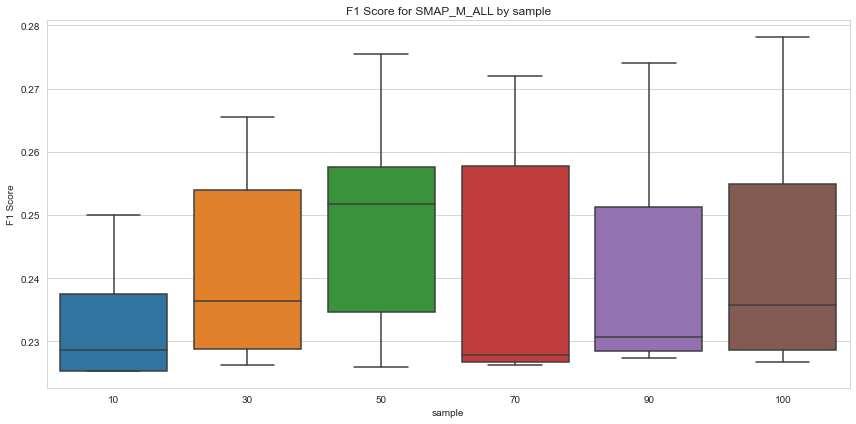

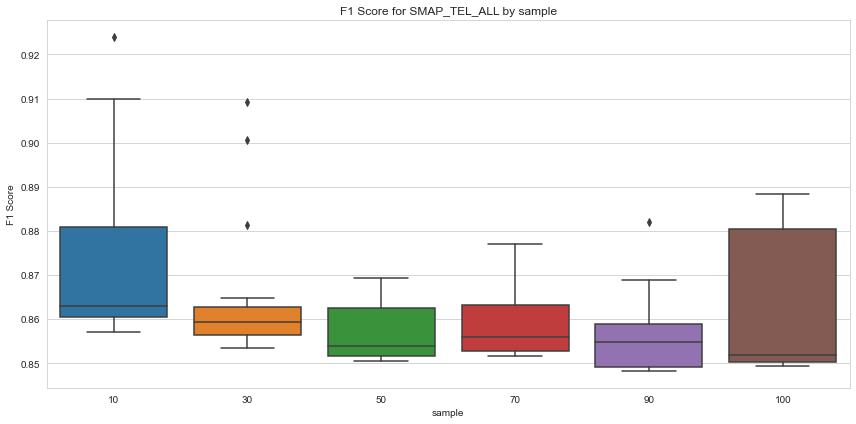

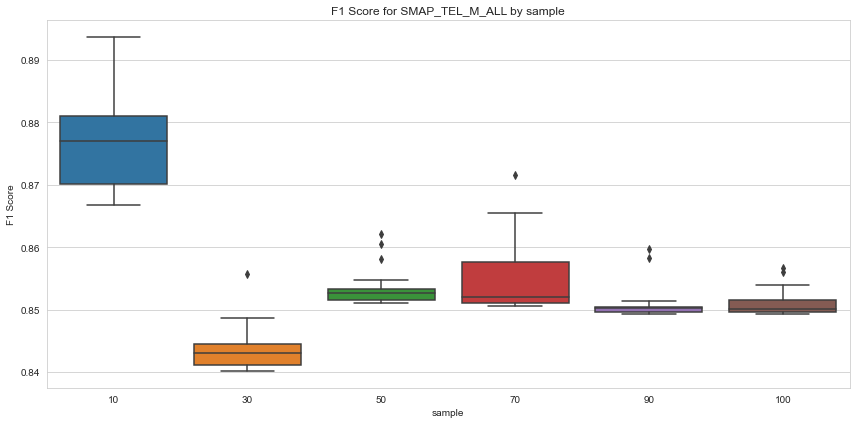

In [20]:
smap_all, smap_tel_all, smap_tel_m_all = plot_box_sampling(data['smap_all'], 'smap_all')

## <font color=red>MSL</font>

In [21]:
df_msl = data['msl'].get(['Dataset', 'F1 Score', 'Precision', 'Recall', 'Anomalies']).groupby(['Dataset']).mean()
df_msl

,F1 Score,Precision,Recall,Anomalies
Dataset,,,,
msl_m,0.200051,0.116341,0.719310,0.105332
msl_m_10,0.200547,0.113697,0.818261,0.105339
msl_m_30,0.200163,0.114516,0.781991,0.105333
msl_m_50,0.199828,0.113949,0.757058,0.105337
msl_m_70,0.198787,0.112240,0.841217,0.105337
msl_m_90,0.197862,0.112915,0.781240,0.105333
msl_tel,0.731624,0.752866,0.754158,0.425733
msl_tel_10,0.763174,0.791264,0.763160,0.425733
msl_tel_30,0.728562,0.727871,0.769912,0.425733


In [22]:
df_msl_all = data['msl_all'].get(['Dataset', 'F1 Score', 'Precision', 'Recall', 'Anomalies']).groupby(['Dataset']).mean()
df_msl_all

,F1 Score,Precision,Recall,Anomalies
Dataset,,,,
msl_m,0.200051,0.116341,0.719310,0.105332
msl_m_all_10,0.224028,0.132519,0.727162,0.105400
msl_m_all_30,0.218316,0.127188,0.772020,0.108600
msl_m_all_50,0.208176,0.120977,0.751667,0.107157
msl_m_all_70,0.199464,0.114524,0.768283,0.104433
msl_m_all_90,0.198666,0.113135,0.793658,0.105033
msl_tel,0.731624,0.752866,0.754158,0.425733
msl_tel_all_10,0.742469,0.723528,0.802991,0.434600
msl_tel_all_30,0.765099,0.787925,0.765499,0.408067


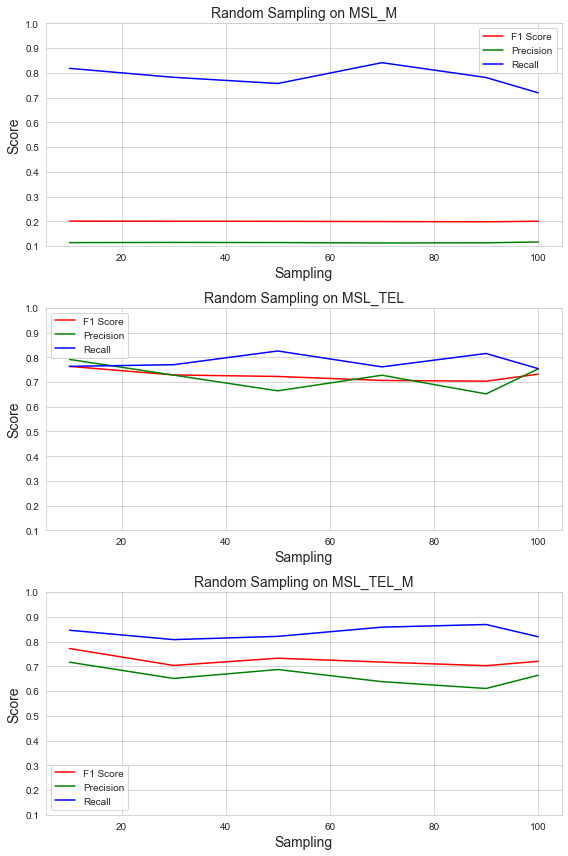

In [23]:
plot_sampling(df_msl, 'msl')

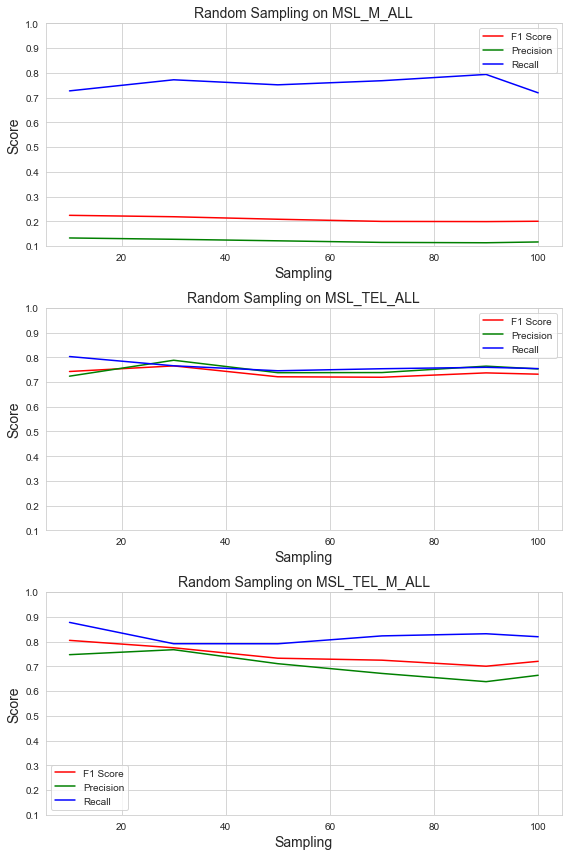

In [24]:
plot_sampling(df_msl_all, 'msl_all')

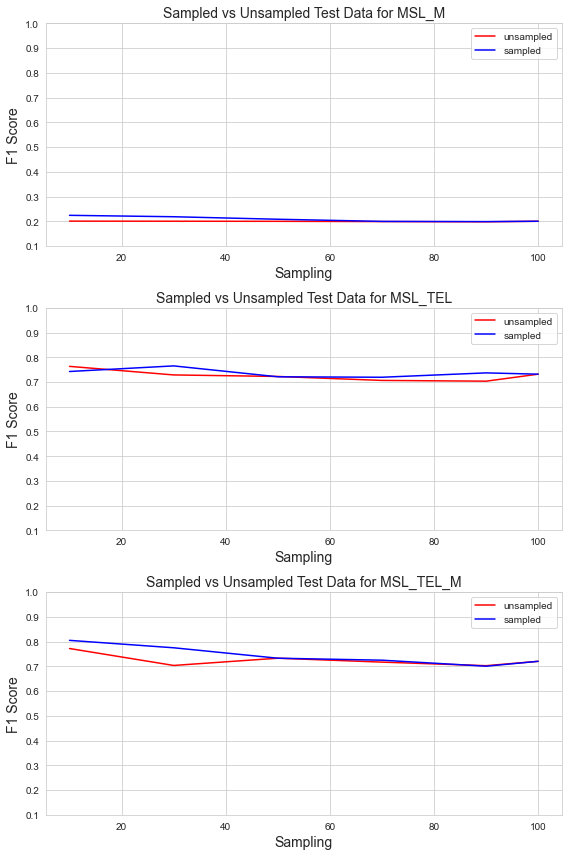

In [25]:
plot_sampling_all(df_msl, df_msl_all, 'msl')

## Min Max vs No Scaling
* Compare F1 Score, Precision and Recall for telemetry sets with and without min max scaling

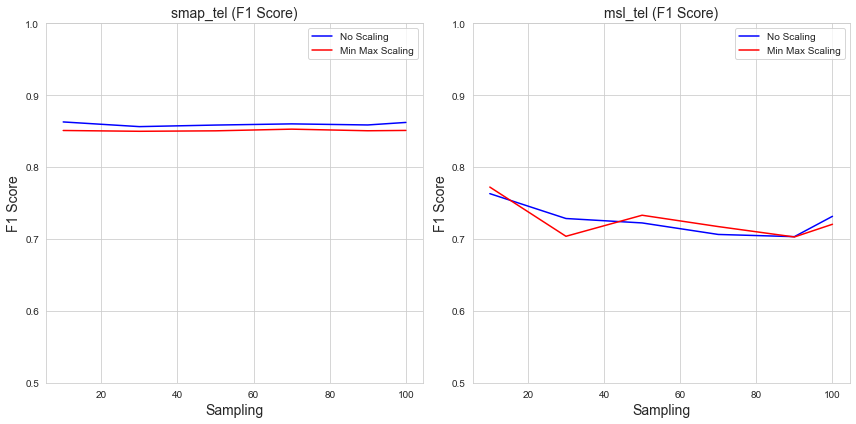

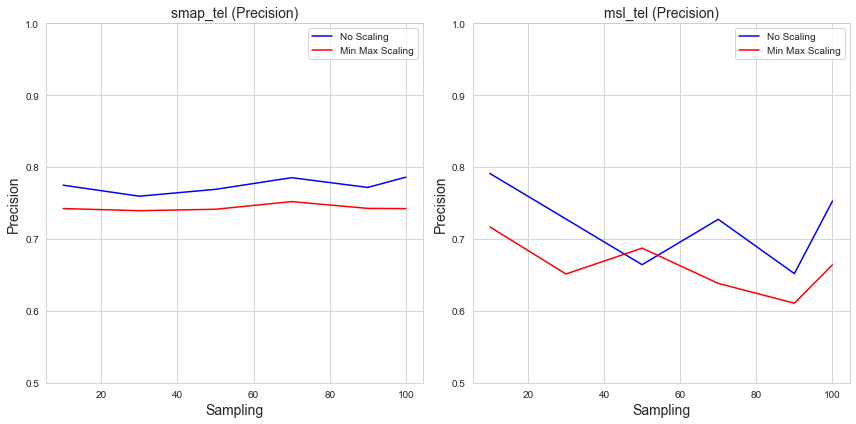

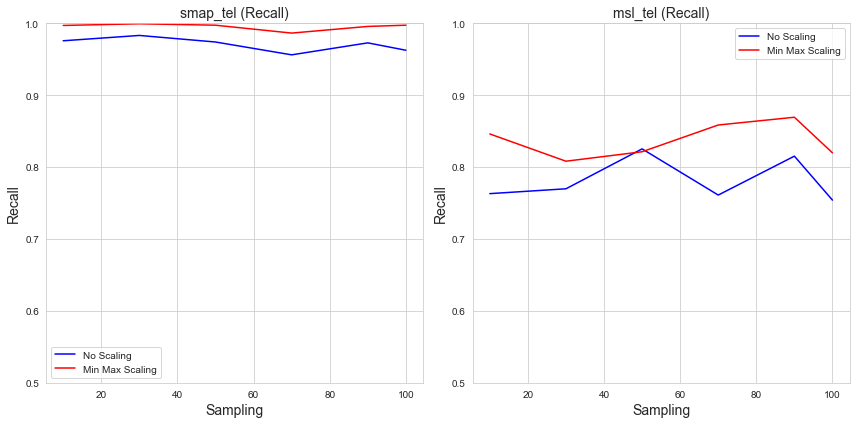

In [26]:
plot_telemetry(df_smap, df_msl)

# Hyper Parameters Comparison
* Compare Slide_Win, FC_Layer_Num and TopK for SWaT, SMAP and MSL values via box plot

## <font color='red'>swat</font>

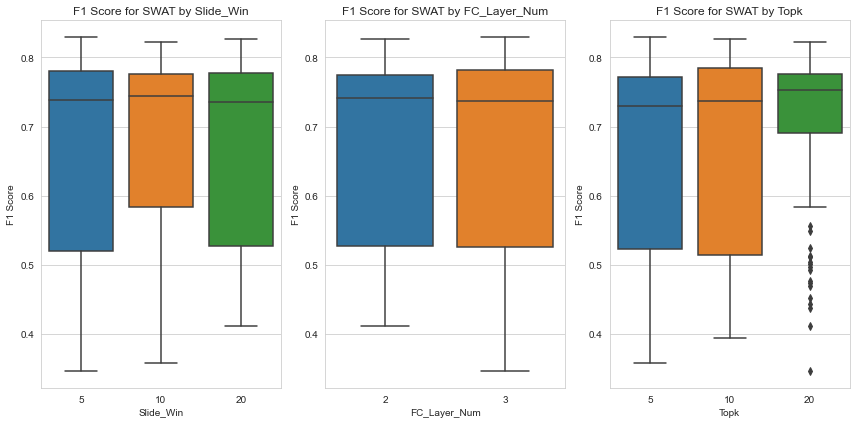

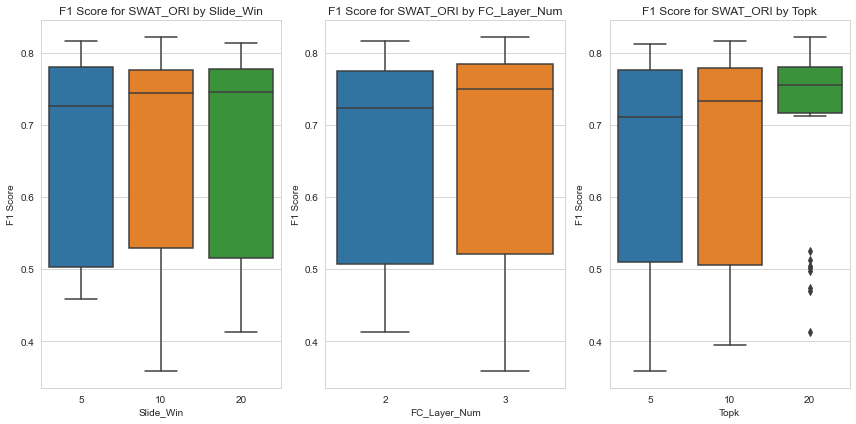

In [27]:
data_swat, data_swat_ori = plot_parameter(data['swat'], 'swat')

## <font color='red'>swat_all</font>

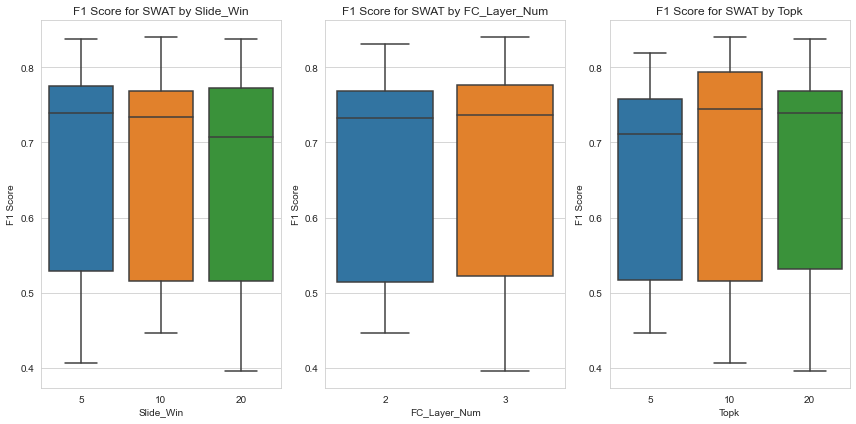

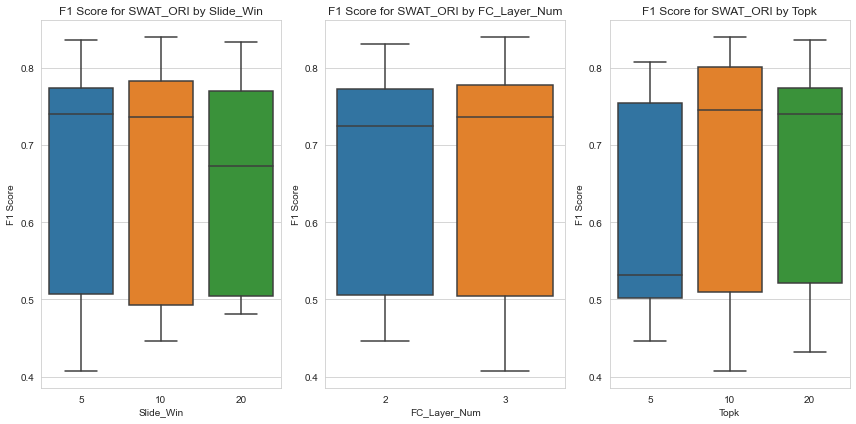

In [28]:
swat_all, swat_ori_all = plot_parameter(data['swat_all'], 'swat')

## <font color='red'>smap</font>

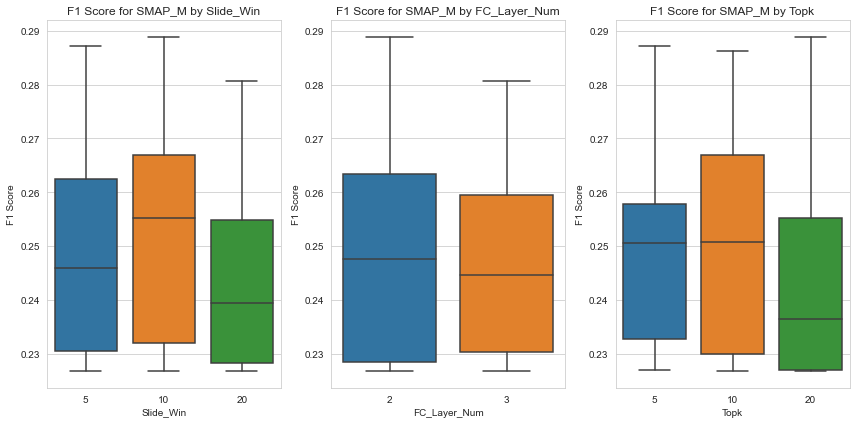

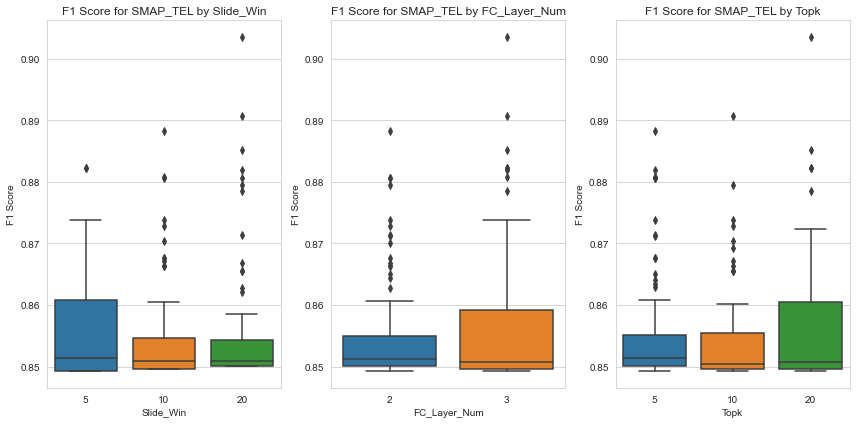

In [29]:
smap, smap_tel = plot_parameter(data['smap'], 'smap')

## <font color='red'>smap_all</font>

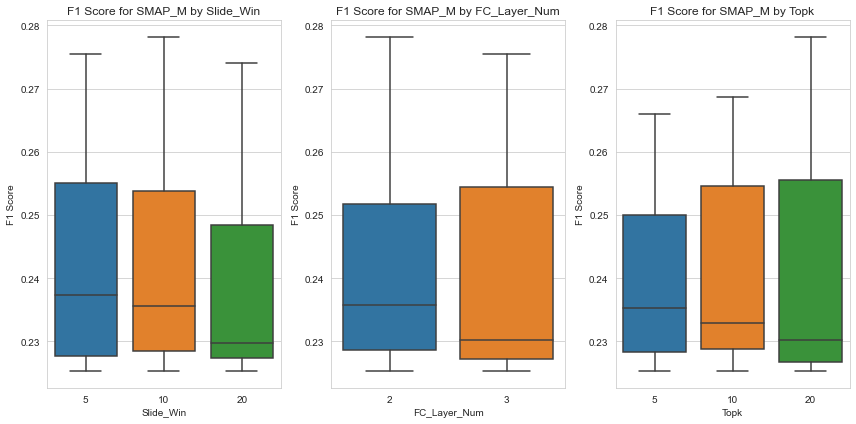

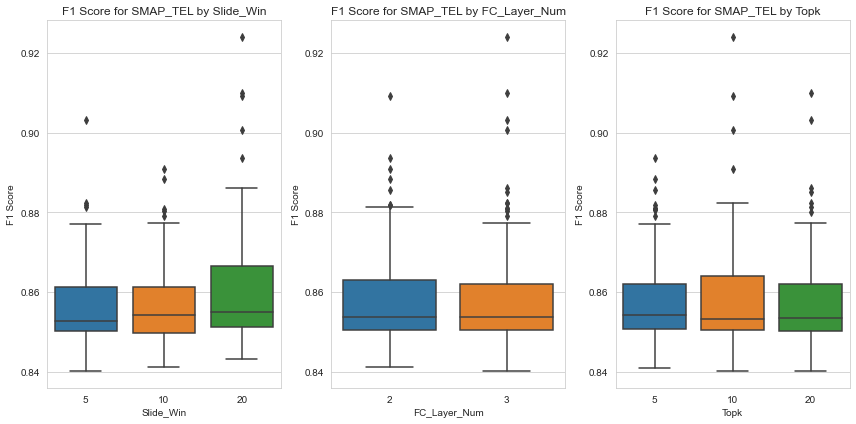

In [30]:
smap_all, smap_tel_all = plot_parameter(data['smap_all'], 'smap')

## <font color='red'>msl</font>

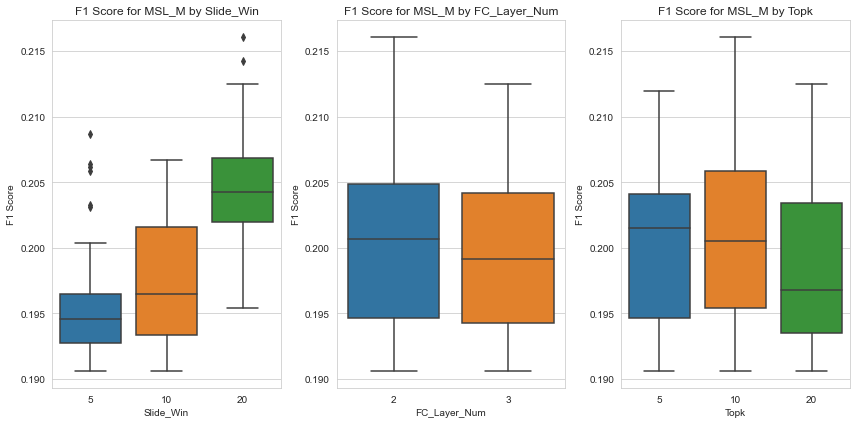

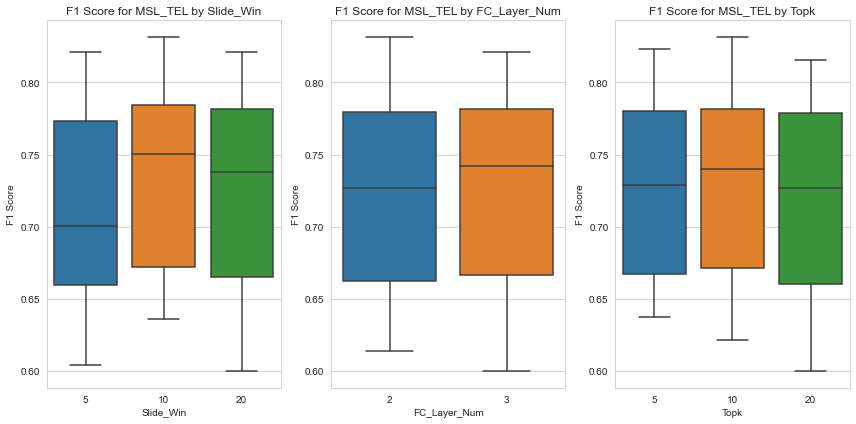

In [31]:
msl, msl_tel = plot_parameter(data['msl'], 'msl')

## <font color='red'>msl_all</font>

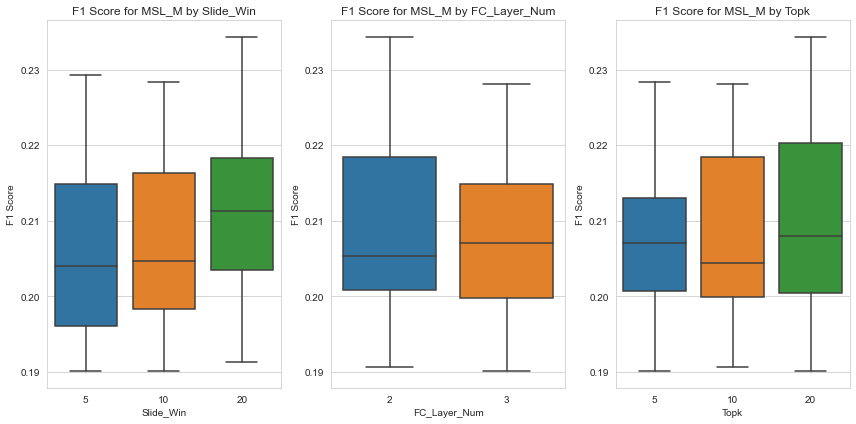

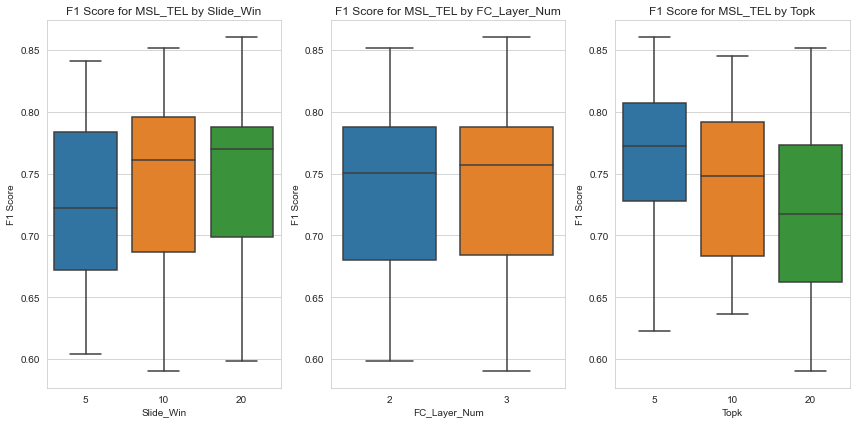

In [32]:
msl_all, msl_tel_all = plot_parameter(data['msl_all'], 'msl')